In [7]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.nn.functional import softmax
from tqdm.auto import tqdm
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#get the data
# https://www.dropbox.com/scl/fi/0n4wpzsqo5lh4enkwimrv/data_gold.csv?rlkey=94bfgrvvooaiz385a75gryent&st=lr696zyx&dl=0

In [3]:
# Read the CSV
df = pd.read_csv('data_gold.csv')

# Step 1: Filter only rows where headline starts with "PRECIOUS"
df = df[df['headline'].str.startswith('PRECIOUS', na=False)].copy()

# Step 2: Remove "PRECIOUS-" from the headline
df['headline'] = df['headline'].str.replace(r'^PRECIOUS-', '', regex=True)

# Step 3: Function to clean the body text
def clean_body(text):
    if pd.isna(text):
        return text
    
    # First, normalize whitespace (tabs, newlines, etc.) to spaces for processing
    # But we want to keep certain newlines, so let's be more careful
    
    # The synopsis pattern is:
    # - Starts with bullet points (* followed by text)
    # - May have "(Updates with...)" or similar
    # - Has "By Author Name"
    # - Then "Date (Reuters) -" which marks the start of the actual article
    
    # Pattern to match everything before "(Reuters) -" and remove it
    # The article starts after "Date (Reuters) - "
    pattern = r'^.*?\b[A-Z][a-z]{2}\s+\d{1,2}\s+\(Reuters\)\s*-\s*'
    
    cleaned = re.sub(pattern, '', text, flags=re.DOTALL)
    
    return cleaned

# Step 4: Function to flatten whitespace (replace all whitespace with single spaces)
def flatten_whitespace(text):
    if pd.isna(text):
        return text
    # Replace all whitespace (newlines, tabs, multiple spaces) with single space
    return re.sub(r'\s+', ' ', text).strip()

# Apply cleaning to body
df['body'] = df['body'].apply(clean_body)

# Flatten whitespace in all text columns
df['headline'] = df['headline'].apply(flatten_whitespace)
df['body'] = df['body'].apply(flatten_whitespace)

# Convert first_created to datetime to extract year (handle mixed formats)
df['first_created'] = pd.to_datetime(df['first_created'], format='ISO8601', utc=True)
df['year'] = df['first_created'].dt.year

# Save the cleaned CSV
output_path = 'data_gold_cleaned.csv'
df.to_csv(output_path, index=False)

In [5]:
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert", clean_up_tokenization_spaces=True)
model = BertForSequenceClassification.from_pretrained("ProsusAI/finbert")

df = pd.read_csv("data_gold_cleaned.csv")

def analyze_sentiment(text):
    """Analyze sentiment in a single pass without chunking."""
    if not isinstance(text, str) or text.strip() == "":
        return "neutral", [0.0, 0.0, 1.0]

    text = text.strip()
    try:
        # Tokenize once; rely on truncation to fit model max length (512 tokens)
        tokenized = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        output = model(**tokenized)
        probs = softmax(output.logits, dim=1)[0].tolist()

        if len(probs) != 3:
            raise RuntimeError("Unexpected output shape")

        labels = ["positive", "negative", "neutral"]
        sentiment = labels[probs.index(max(probs))]
        return sentiment, probs
    except Exception as ex:
        print("Error in analyze_sentiment:", ex)
        return "neutral", [0.0, 0.0, 1.0]



# Process and save by year to avoid losing progress
all_results = []

for year in sorted(df['year'].unique()):
    # If the output file for this year already exists, skip it
    year_output_file = f"sentiment_data_cleaned/data_gold_finbert_{year}.csv"
    if os.path.exists(year_output_file):
        print(f"Skipping year {year} (output file already exists)")
        year_df = pd.read_csv(year_output_file)
        all_results.append(year_df)
        continue

    year_df = df[df['year'] == year].copy()
    year_sentiments = []
    year_probabilities = []

    # Main loop
    for article_body in tqdm(year_df['body'], desc=f"Scoring {year} articles with FinBERT"):
        try:
            sentiment, scores = analyze_sentiment(article_body)
        except Exception as ex:
            print("Error scoring text:", ex)
            sentiment, scores = "neutral", [0.0, 0.0, 1.0]

        year_sentiments.append(sentiment)
        year_probabilities.append(scores)

    year_df['sentiment'] = year_sentiments
    year_df['probs'] = year_probabilities
    year_df['sent_score'] = year_df['probs'].apply(lambda p: p[0] - p[1])

    # Save this year's results immediately
    year_df.to_csv(year_output_file, index=False)
    all_results.append(year_df)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

c:\Users\mlascoe\AppData\Local\anaconda3\envs\ml\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mlascoe\.cache\huggingface\hub\models--ProsusAI--finbert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]


Processing year 2010 (1691 articles)


Scoring 2010 articles with FinBERT:   0%|          | 0/1691 [00:00<?, ?it/s]

Saved 2010 results to sentiment_data_cleaned/data_gold_finbert_2010.csv

Processing year 2011 (1793 articles)


Scoring 2011 articles with FinBERT:   0%|          | 0/1793 [00:00<?, ?it/s]

Saved 2011 results to sentiment_data_cleaned/data_gold_finbert_2011.csv

Processing year 2012 (1591 articles)


Scoring 2012 articles with FinBERT:   0%|          | 0/1591 [00:00<?, ?it/s]

Saved 2012 results to sentiment_data_cleaned/data_gold_finbert_2012.csv

Processing year 2013 (1459 articles)


Scoring 2013 articles with FinBERT:   0%|          | 0/1459 [00:00<?, ?it/s]

Saved 2013 results to sentiment_data_cleaned/data_gold_finbert_2013.csv

Processing year 2014 (1444 articles)


Scoring 2014 articles with FinBERT:   0%|          | 0/1444 [00:00<?, ?it/s]

Saved 2014 results to sentiment_data_cleaned/data_gold_finbert_2014.csv

Processing year 2015 (1252 articles)


Scoring 2015 articles with FinBERT:   0%|          | 0/1252 [00:00<?, ?it/s]

Saved 2015 results to sentiment_data_cleaned/data_gold_finbert_2015.csv

Processing year 2016 (1345 articles)


Scoring 2016 articles with FinBERT:   0%|          | 0/1345 [00:00<?, ?it/s]

Saved 2016 results to sentiment_data_cleaned/data_gold_finbert_2016.csv

Processing year 2017 (1326 articles)


Scoring 2017 articles with FinBERT:   0%|          | 0/1326 [00:00<?, ?it/s]

Saved 2017 results to sentiment_data_cleaned/data_gold_finbert_2017.csv

Processing year 2018 (1427 articles)


Scoring 2018 articles with FinBERT:   0%|          | 0/1427 [00:00<?, ?it/s]

Saved 2018 results to sentiment_data_cleaned/data_gold_finbert_2018.csv

Processing year 2019 (1634 articles)


Scoring 2019 articles with FinBERT:   0%|          | 0/1634 [00:00<?, ?it/s]

Saved 2019 results to sentiment_data_cleaned/data_gold_finbert_2019.csv

Processing year 2020 (1693 articles)


Scoring 2020 articles with FinBERT:   0%|          | 0/1693 [00:00<?, ?it/s]

Saved 2020 results to sentiment_data_cleaned/data_gold_finbert_2020.csv

Processing year 2021 (1783 articles)


Scoring 2021 articles with FinBERT:   0%|          | 0/1783 [00:00<?, ?it/s]

Saved 2021 results to sentiment_data_cleaned/data_gold_finbert_2021.csv

Processing year 2022 (1766 articles)


Scoring 2022 articles with FinBERT:   0%|          | 0/1766 [00:00<?, ?it/s]

Saved 2022 results to sentiment_data_cleaned/data_gold_finbert_2022.csv

Processing year 2023 (1664 articles)


Scoring 2023 articles with FinBERT:   0%|          | 0/1664 [00:00<?, ?it/s]

Saved 2023 results to sentiment_data_cleaned/data_gold_finbert_2023.csv

Processing year 2024 (1552 articles)


Scoring 2024 articles with FinBERT:   0%|          | 0/1552 [00:00<?, ?it/s]

Saved 2024 results to sentiment_data_cleaned/data_gold_finbert_2024.csv

Processing year 2025 (139 articles)


Scoring 2025 articles with FinBERT:   0%|          | 0/139 [00:00<?, ?it/s]

Saved 2025 results to sentiment_data_cleaned/data_gold_finbert_2025.csv


In [6]:
# Combine all years and save final complete file
df_complete = pd.concat(all_results, ignore_index=True)
df_complete.to_csv("sentiment_data_cleaned/data_gold_finbert_complete.csv", index=False)
print(f"All years processed and saved to data_gold_finbert_complete.csv")

All years processed and saved to data_gold_finbert_complete.csv


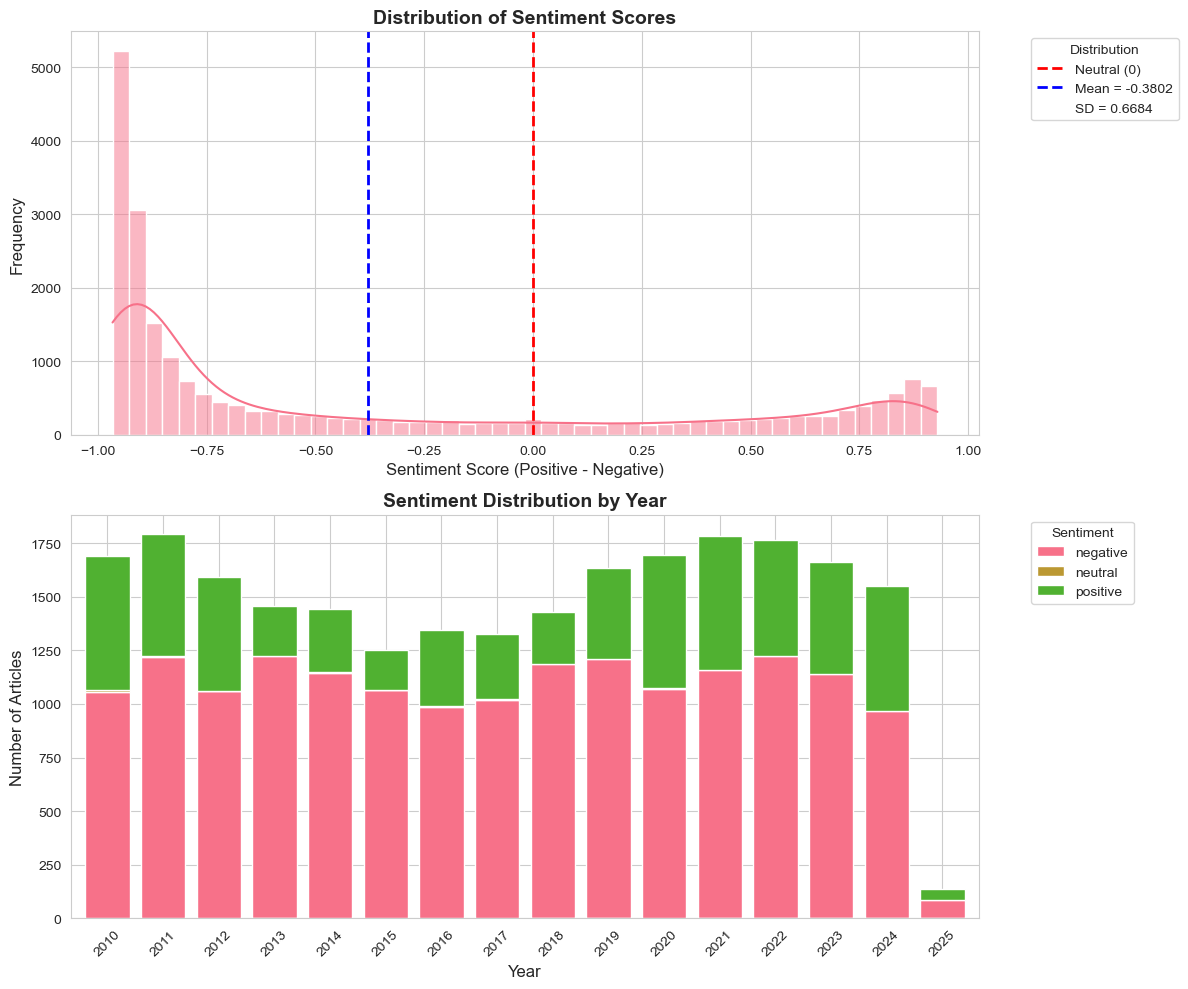

In [27]:
# Set style for better-looking plots
sns.set_style("whitegrid")
sns.set_palette("husl")

# Create a figure with multiple subplots
# Clean aligned visualizations for paper/presentation
fig, (ax1, ax4) = plt.subplots(2, 1, figsize=(12, 10))

# Calculate statistics for the legend
mean_score = df_complete['sent_score'].mean()
std_score = df_complete['sent_score'].std()

# 1. Distribution of Sentiment Scores
sns.histplot(data=df_complete, x='sent_score', bins=50, kde=True, ax=ax1)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Neutral (0)')
ax1.axvline(x=mean_score, color='blue', linestyle='--', linewidth=2, label=f'Mean = {mean_score:.4f}')
ax1.axvline(x=std_score, ymin=0, ymax=0, color='white', linestyle='--', linewidth=2, label=f'SD = {std_score:.4f}')
ax1.set_title('Distribution of Sentiment Scores', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sentiment Score (Positive - Negative)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
# Create custom legend with mean and SD
ax1.legend(title=f'Distribution', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# 2. Sentiment over Time (by Year)
sentiment_by_year = df_complete.groupby(['year', 'sentiment']).size().unstack(fill_value=0)
sentiment_by_year.plot(kind='bar', stacked=True, ax=ax4, width=0.8)
ax4.set_title('Sentiment Distribution by Year', fontsize=14, fontweight='bold')
ax4.set_xlabel('Year', fontsize=12)
ax4.set_ylabel('Number of Articles', fontsize=12)
ax4.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('sentiment_clean_visualizations.png', dpi=400, bbox_inches='tight')
plt.show()